# Computer Vision, Assignment 4: Model Fitting and Local Optimization

In this assignment, you will how to robustly estimate camera parameters and how to jointly optimize the scene geometry. 
You will mainly use RANSAC and Bundle Adjustment.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


### Reusing functions from prior assignment:
In this assignment, you will build on your prior work. Many of the exercises require you to use functions implemented in assignment 3. To do so most easily, we recommend that you paste those functions into `helpers.py` and import them here by e.g. `from helpers import estimate_F_DLT`. 

In [1]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Note: These functions are provided for your convenience, use them where needed
from supplied import pflat, plot_camera, rital,psphere


# Estimate Essential Matrix using RANSAC

#### *Theoretical exercises 1-2* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/round_church1.jpg" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/round_church2.jpg" width="250px">
    <img alt="right" src="data/round_church_recon.png" width="250px">
    <figcaption>Figure 1: Two images of a church and an example of the obtained 3D reconstruction.</figcaption>
</figure>

The goal of this exercise is to robustly estimate essential matrix $E$ from point matches between the two images. For this, we will use RANSAC with an eight point solver.

The data provided contains calibration matrix $K$, which is the same for both images, and a cell $\mathbf{x}$ with matched image points for the two images. Note that $\mathbf{x}$ are noisy and contain some fraction of outliers.

In [2]:
# First we supply some preliminaries, just loading images and data
img1 = plt.imread('./data/round_church1.jpg')
img2 = plt.imread('./data/round_church2.jpg')

data = sp.io.loadmat('./data/compEx1data.mat')
K = data["K"]
x = [x.astype(np.float32) for x in data['x'][0]]

### Task 1.1

First, compute the essential matrix $E$ with an eight point algorithm using all the point correspondences. Remember to normalize image points using $K$ beforehand. Then convert it to a fundamental matrix $F$. Recall that in Assignment 3, you created functions `estimate_F_DLT(x1s, x2s)`, `enforce_essential(E_approx)`, and `convert_E_to_F(E,K1,K2)`.

In [3]:
# Optional imports
from helpers import estimate_F_DLT, enforce_essential, convert_E_to_F, enforce_fundamental

In [4]:
# ------ Your code here ------

# Insert code where you compute the essential matrix
x1=x[0]
x2=x[1]
x1_norm=np.linalg.inv(K)@x1
x2_norm=np.linalg.inv(K)@x2 
E=estimate_F_DLT(x1_norm,x2_norm)
E=enforce_essential(E)

# Insert code where you transform the essential matrix to a fundamental matrix
F=convert_E_to_F(E,K,K)

### Task 1.2 

Compute the epipolar lines $\mathbf{l}_2 = F\mathbf{x}_1$ and $\mathbf{l}_1 = F^T\mathbf{x}_2$. Compute the RMS distance between the image points ($\mathbf{x}_1$ and $\mathbf{x}_2$) and corresponding epipolar lines ($\mathbf{l}_1$ and $\mathbf{l}_2$, respectively). 

\begin{align}
& e_{RMS} = \sqrt{\frac{1}{2m}
\left(
\sum_{i=1}^{m} d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + 
\sum_{i=1}^{m} d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)
\right)
},\nonumber \\
& \text{where }~d(\mathbf{x}, \mathbf{l}) = \frac{|l_{1}x_{1}+l_{2}x_{2}+l_{3}|}{\sqrt{l_{1}^2+l_{2}^2}}.
\end{align}

In Assignment 3, you implemented the distances $d(\mathbf{x}, \mathbf{l})$ from image points to the corresponding epipolar lines for the second image in the function `compute_epipolar_errors(F, x1s, x2s)`.


**HINT:** If you transpose the fundamental matrix and change the order of the correpondences, i.e. run `compute_epipolar_errors(F.T, x2s, x1s)` you can obtain the errors to the epipolar lines in the first image.

In [5]:
# Optional imports
from helpers import compute_epipolar_errors

In [6]:
# ------ Your code here ------

# Compute the epipolar lines, l1 and l2 
l2=F@x1
l1=F.T@x2
# Compute the RMS distance
error_2=compute_epipolar_errors(F,x1,x2)
error_1=compute_epipolar_errors(F.T,x2,x1)
m = x1.shape[1]  
rms_error = np.sqrt((np.sum(error_1**2) + np.sum(error_2**2)) / (2 * m))
print(f'RMS Epipolar Error: {rms_error}')



RMS Epipolar Error: 155.95832213754292


### Task 1.3

Plot two separate histograms with 100 bins for the epipolar errors $\{d({\mathbf{x}_1}_i,{\mathbf{l}_1}_i)\}$ in the first image and $\{d({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\}$ in the second image, respectively. See for example your solution to Assignment 3 Computer Exercise 2.2 for some code on plotting histograms.

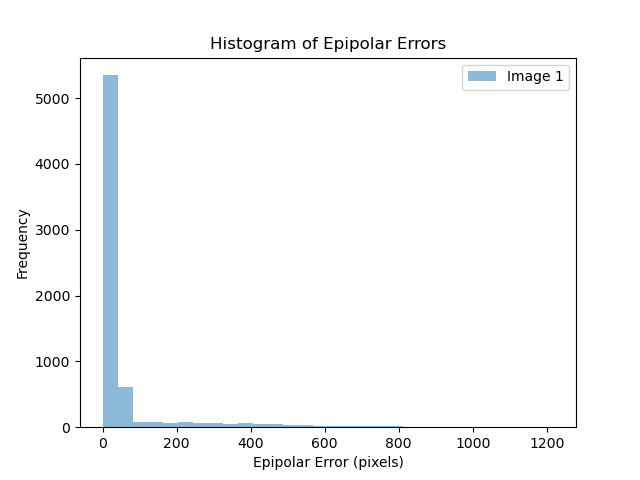

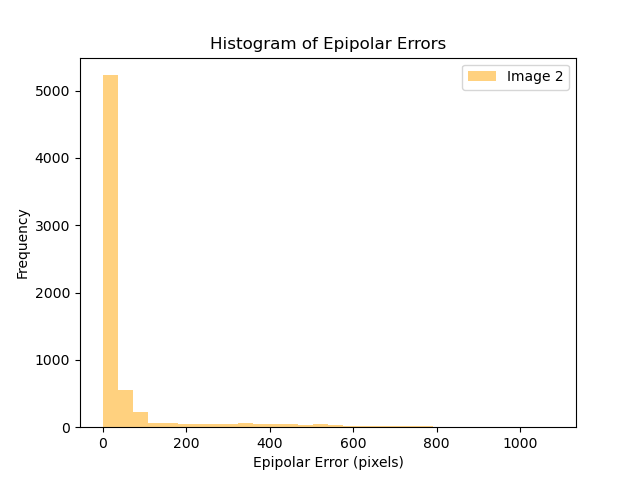

In [7]:
# ------ Your code here ------
plt.figure()
plt.hist(error_1,bins=30,alpha=0.5,label='Image 1')
plt.xlabel('Epipolar Error (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Epipolar Errors')
plt.legend()
plt.show()
plt.figure()
plt.hist(error_2,bins=30,alpha=0.5,label='Image 2',color='orange')
plt.xlabel('Epipolar Error (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Epipolar Errors')
plt.legend()
plt.show()

### Task 1.4

Pick 20 points in the first image at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same image using the function `rital`. Repeat the plot for the second image.

Q: **Do the plots look reasonable, are points close to the epipolar lines? If not, what do you think could be the cause of the bad estimate?** 

A: The plots look reasonable. Most points are close to the eopipolar lines, some are not. The points that are far from the lines are likely outliers (incorrect matches) included in the random sample, rather than a result of a bad estimate.

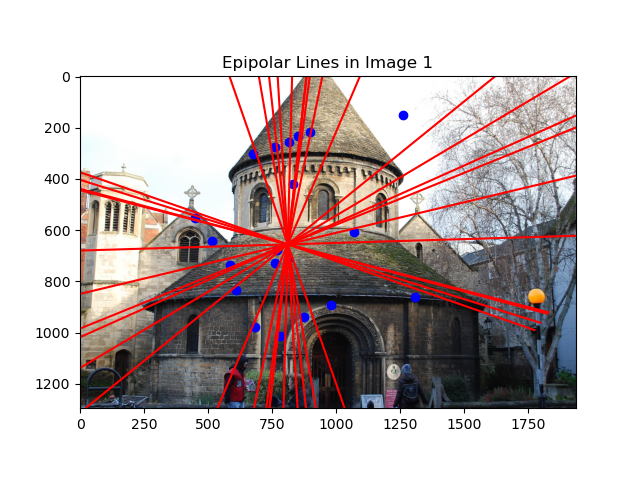

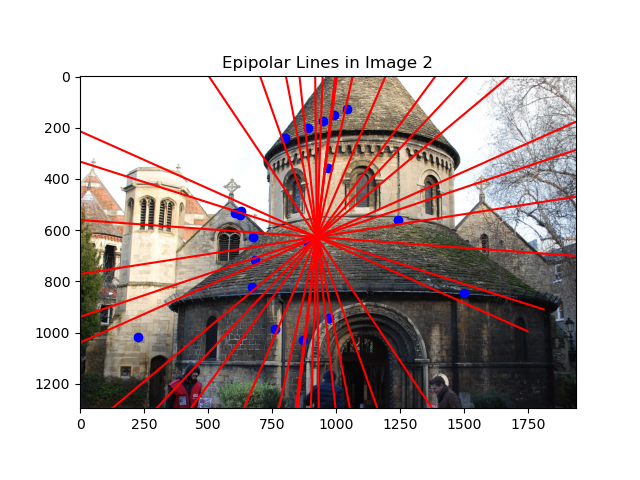

No such comm: 1829561f333343ebb1c0d5cb4b979977
No such comm: 1829561f333343ebb1c0d5cb4b979977
No such comm: 1829561f333343ebb1c0d5cb4b979977
No such comm: 1829561f333343ebb1c0d5cb4b979977
No such comm: 1829561f333343ebb1c0d5cb4b979977
No such comm: 1829561f333343ebb1c0d5cb4b979977
No such comm: 6ae0647b51d842339ac22fc79c200bbe
No such comm: 6ae0647b51d842339ac22fc79c200bbe
No such comm: 6ae0647b51d842339ac22fc79c200bbe
No such comm: 6ae0647b51d842339ac22fc79c200bbe
No such comm: 6ae0647b51d842339ac22fc79c200bbe
No such comm: 6ae0647b51d842339ac22fc79c200bbe


In [8]:
# ------ Your code here ------
indices = np.random.choice(m, size=20, replace=False)
x1_sampled = x1[:, indices]
l1_sampled = l1[:, indices]
plt.close('all')
plt.figure()
plt.imshow(img1)
rital(l1_sampled.T, st='r-')
plt.scatter(x1_sampled[0, :], x1_sampled[1, :], c='b', marker='o')
plt.title('Epipolar Lines in Image 1')
plt.show()

x2_sampled = x2[:, indices]
l2_sampled = l2[:, indices]
plt.figure()
plt.imshow(img2)
rital(l2_sampled.T, st='r-')
plt.scatter(x2_sampled[0, :], x2_sampled[1, :], c='b', marker='o')
plt.title('Epipolar Lines in Image 2')
plt.show()


### Task 1.5

Next, use RANSAC to robustly compute $E$. Create a function `estimate_E_robust(x1, x2, eps)` that does it, where `eps` is the inlier threshold. Remember again to normalize `x1` and `x2` using $K$ beforehand. Note that for this problem of estimating $E$, a point correspondence $({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$ is a single measurement. Use the same eight point solver as above.

Note that this time only a subset of correspondences will be used by this solver (since in the RANSAC loop, you first randomly sample a subset of correspondences and then compute candidate $E$ from this subset).

Finally, to make RANSAC work, you need to implement an error function that measures how far a single measurement ($({\mathbf{x}_1}_i, {\mathbf{x}_2}_i)$) is to the candidate model ($E$). Use the following error function: $\frac12 \left ( d^2({\mathbf{x}_1}_i,{\mathbf{l}_1}_i) + d^2({\mathbf{x}_2}_i,{\mathbf{l}_2}_i)\right )$, where the epipolar lines ${\mathbf{l}_j}_i$ are computed as before but using $E$ (and therefore are normalized). This error should be familiar to you based on the previous exercises, reuse your implementation from there!

A suggested inlier threshold is 2px (which should also be normalized, see function description below). 

Q: **How many inliers did you get for the returned solution of $E$?**

A: I found 5403 inliers (out of a total of 6822 matches).

In [9]:
def estimate_E_robust(x1, x2, eps, seed=None):
    """
    RANSAC estimate of essential matrix using normalized correspondences x1 and x2 and a normalized threshold.
    Note: Make sure to normalize things before using it in this function!
    -------------------------------------------
    x1: Normalized keypoints in image 1 - 3xN np.array or 2xN np.array, as you desire 
    x2: Normalized keypoints in image 2 - 3xN np.array or 2xN np.array, as you desire 
    eps: Normalized inlier threshold - float

    Returns:
    E: 3x3 essential matrix
    inliers: The inlier points
    errs: The epipolar errors
    iters: How many iterations it took
    """
    # TIPS: 
    # * You can use the already created functions, enforce_essential, estimate_F_DLT, and compute_epipolar_errors
    # * Normalizing the pixel threshold can be done by e.g. eps = threshold_px / K[0,0]
    # * To create an estimate for E using DLT for a random subset of calibrated correspondences...
    # ...you can chain your functions like: E = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))

    # * Pseudo code for computing inliers:
    # e1 = compute_epipolar_errors(E, x1, x2)**2 
    # e2 = compute_epipolar_errors(E.T, x2, x1)**2
    # inliers = (1/2)*(e1+e2) < eps**2
    
    # ------ Your code here ------
    if seed is not None:
        np.random.seed(seed)    

    m = x1.shape[1]
    max_iterations = 1000  
    confidence = 0.99  
    sample_size = 8
    iters = 0

    best_inliers = None
    best_E = None
    best_inlier_count = 0

    while iters < max_iterations:
        randind = np.random.choice(m, size=sample_size, replace=False)
        
        try:
            E_candidate = enforce_essential(estimate_F_DLT(x1[:, randind], x2[:, randind]))
        except:
            iters += 1
            continue
        
        e1 = compute_epipolar_errors(E_candidate, x1, x2)**2 
        e2 = compute_epipolar_errors(E_candidate.T, x2, x1)**2
        errors = 0.5 * (e1 + e2)  
        
        inliers_mask = errors < eps**2
        num_inliers = np.sum(inliers_mask)
        
        if num_inliers > best_inlier_count:
            best_inlier_count = num_inliers
            best_inliers = inliers_mask
            best_E = E_candidate
            
            if num_inliers > 0:
                inlier_ratio = num_inliers / m
                required_iterations = int(np.ceil(np.log(1-confidence) / np.log(1-inlier_ratio**sample_size)))
                max_iterations = min(max_iterations, required_iterations)
        
        iters += 1

    print(f"RANSAC: {iters} iterations, {best_inlier_count}/{m} inliers")

    if best_inlier_count >= sample_size:
        x1_inliers = x1[:, best_inliers]
        x2_inliers = x2[:, best_inliers]
        best_E = enforce_essential(estimate_F_DLT(x1_inliers, x2_inliers))
        
        e1_refined = compute_epipolar_errors(best_E, x1_inliers, x2_inliers)**2
        e2_refined = compute_epipolar_errors(best_E.T, x2_inliers, x1_inliers)**2
        errs = np.sqrt(0.5 * (e1_refined + e2_refined))  
    else:
        errs = np.array([]) 

    E = best_E
    inliers = best_inliers
   
    return E, inliers, errs, iters

### Task 1.6

Again, compute the RMS distance between the image points and corresponding estimated epipolar lines in both images. Also plot a histogram of epipolar errors for both images as before. 

Q: **Which is the better estimate of the essential matrix, and why?** Repeat plotting 20 random points with the corresponding epipolar lines, but this time pick random points from the subset of correspondences that are ***inliers***.

A: The essential matrix after RANSAC is better. The RMS distance is samller and the hisograms show that epipolar errors are concentrated within a smaller range after applying RANSAC. The figures also show that the epipolar lines pass directly through the selected points.


RANSAC: 28 iterations, 5403/6822 inliers
RMS Epipolar Error after RANSAC: 0.5857679669324891


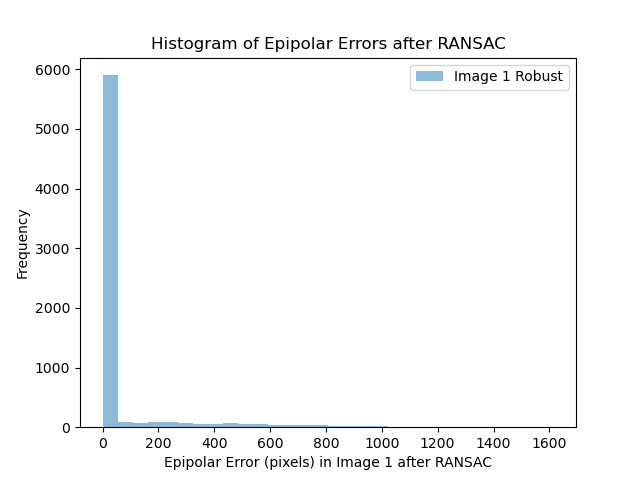

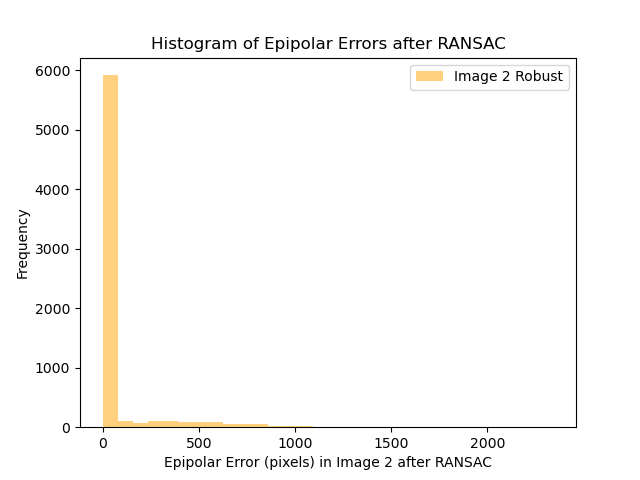

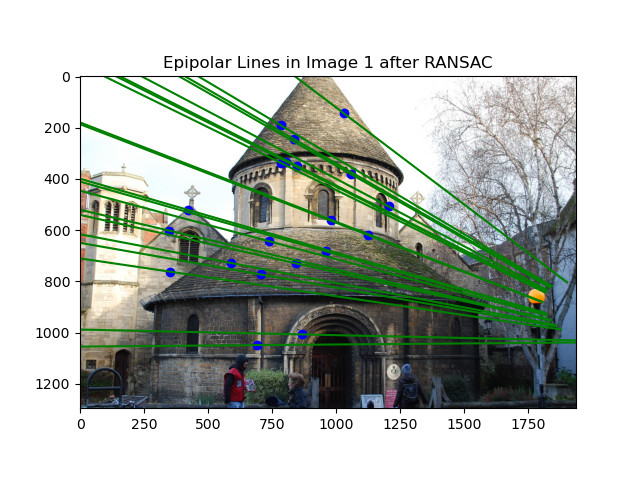

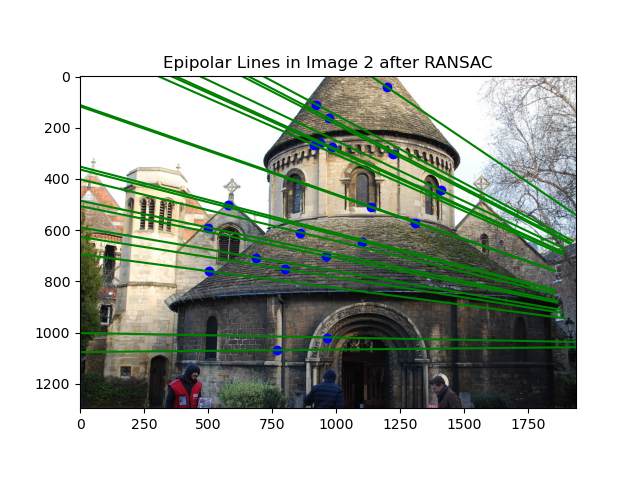

No such comm: 4ef46a4ff87040508463700d5a8c5924
No such comm: 8450159b217b46d7907afed11effe929


In [10]:
# ------ Your code here ------
E, inliers, errs, iters = estimate_E_robust(x1_norm, x2_norm, eps=0.001, seed=42)
F_robust = convert_E_to_F(E,K,K)
error_2_robust = compute_epipolar_errors(F_robust, x1, x2)
error_1_robust = compute_epipolar_errors(F_robust.T, x2, x1)
rms_error_robust = np.sqrt((np.sum(error_1_robust[inliers]**2) + np.sum(error_2_robust[inliers]**2)) / (2 * np.sum(inliers)))
print(f'RMS Epipolar Error after RANSAC: {rms_error_robust}')
plt.close('all')

plt.figure()
plt.hist(error_1_robust, bins=30, alpha=0.5, label='Image 1 Robust')
plt.xlabel('Epipolar Error (pixels) in Image 1 after RANSAC')
plt.ylabel('Frequency')
plt.title('Histogram of Epipolar Errors after RANSAC')
plt.legend()
plt.show()

plt.figure()
plt.hist(error_2_robust, bins=30, alpha=0.5, label='Image 2 Robust', color='orange')
plt.xlabel('Epipolar Error (pixels) in Image 2 after RANSAC')
plt.ylabel('Frequency')
plt.title('Histogram of Epipolar Errors after RANSAC')
plt.legend()
plt.show()

indices_robust = np.random.choice(np.where(inliers)[0], size=20, replace=False)
x1_sampled_robust = x1[:, indices_robust]
l1_robust = F_robust.T @ x2[:, indices_robust]

plt.figure()
plt.imshow(img1)
rital(l1_robust.T, st='g-')
plt.scatter(x1_sampled_robust[0, :], x1_sampled_robust[1, :], c='b', marker='o')
plt.title('Epipolar Lines in Image 1 after RANSAC')
plt.show()

x2_sampled_robust = x2[:, indices_robust]
l2_robust = F_robust @ x1[:, indices_robust]

plt.figure()
plt.imshow(img2)
rital(l2_robust.T, st='g-')
plt.scatter(x2_sampled_robust[0, :], x2_sampled_robust[1, :], c='b', marker='o')
plt.title('Epipolar Lines in Image 2 after RANSAC')
plt.show()



## Computer Exercise 2
<figure align="center">
    <img alt="left" src="data/fountain1.png" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/fountain2.png" width="250px">
    <img alt="right" src="data/fountain_recon.png" width="250px">
    <figcaption>Figure 2: Two images of a fountain and an example of the obtained 3D reconstruction.</figcaption>
</figure>

In this exercise you will build a 2-view reconstruction pipeline that connects feature extraction,
matching, robust essential matrix estimation from the previous computer exercise, and triangulation.

You can use the two supplied images from the data and the intrinsics provided. We load the required data for your convenience below:

In [11]:
data = sp.io.loadmat('./data/compEx2data.mat')
K = data['K']
img1 = (plt.imread('./data/fountain1.png') * 255).astype('uint8')
img2 = (plt.imread('./data/fountain2.png') * 255).astype('uint8')

### Task 2.1

We will begin by computing SIFT features and matching them. Since OpenCV has quite a difficult API for this we have supplied some code snippets. And you already learned much of the basics of this from Assignment 2, so we provide some basic code to get you started.

The implementation is based on their official guide for image matching (https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) and uses Lowe's ratio test to filter out matches that are too similar, this should be similar to what you have done in previous assignments.

In [12]:
# Some supplied code on how to compute matches using OpenCV

from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

# We detect keypoints and simultaneously describe them using SIFT
kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)

# We use a k-NN-like system to find the most similar descriptions
all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
# Apply ratio test
# Here we filter out matches that are too similar to other matches (because then they are likely wrong)
# This is standard in OpenCV, see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        matches.append([m])

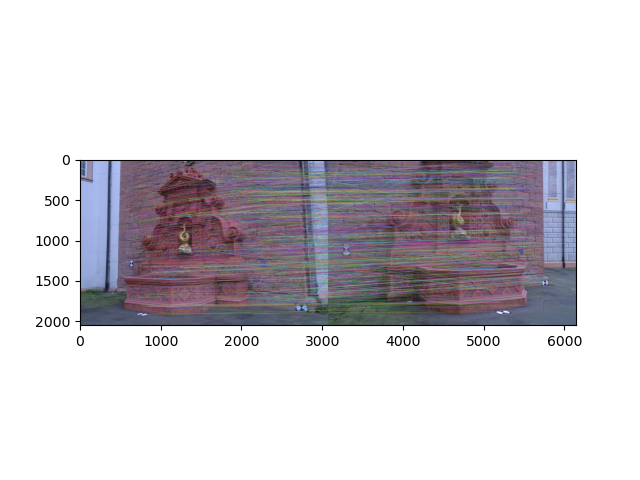

(<matplotlib.image.AxesImage at 0x21cb1232700>, None)

In [13]:
# Run this code for a simple plot of the filtered matches

# Just making sure no other figures are impacting this one
plt.close()
plt.clf()   
plt.cla() 
# Here is some supplied code from https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# Feel free to play around with it
img3 = drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

Q: **Run the code above. Do the matches look reasonable?**

A: The matches look reasonable.

Q: **How many SIFT features did you find for the two images, respectively? How many total matches did you find? How many good matches did you find after the ratio test?**

A: There are 19410 SIFT features in image 1 and 17618 SIFT features in image 2. The number of the total matches is 19140. The number of good matches is 1049.

In [14]:
# ------ Your code here ------

# Count SIFT features per image
feactures_img1 = len(kp1)
feactures_img2 = len(kp2)
print(f'Number of SIFT features in Image 1: {feactures_img1}')
print(f'Number of SIFT features in Image 2: {feactures_img2}')

# Count number of total matches
total_matches = len(all_matches)
print(f'Number of total matches before ratio-test: {total_matches}')
# Count the number of good matches after the ratio-test
good_matches = len(matches)
print(f'Number of good matches after ratio-test: {good_matches}')

Number of SIFT features in Image 1: 19410
Number of SIFT features in Image 2: 17618
Number of total matches before ratio-test: 19410
Number of good matches after ratio-test: 1049


Now we supply a little more code just to make it easier. We extract the keypoints corresponding to the good matches and save them as x1 and x2. We do this because currently the type of kp1 etc... are OpenCV specific

In [15]:
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in matches])
x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
x = np.array([x1, x2])

### Task 2.2

Now you should find the essential matrix describing the transformation between the two images.
Because not all matches are correct, you need to use RANSAC to find a set of good correspondences (inliers). 
To estimate the essential matrix use the function `estimate_E_robust(x1,x2,eps)` that you created in the previous computer exercise.

Q: **How many inliers did you find?**

A: I found 854 inliers.

In [16]:
# ------ Your code here ------

# Compute the essential matrix based on the keypoint matches we just computed between the two images
x1_norm = np.linalg.inv(K) @ x1
x2_norm = np.linalg.inv(K) @ x2
E,inliers,_,_=estimate_E_robust(x1_norm,x2_norm,eps=0.01,seed=42)


# Print the number of inliers
num_inliers = np.sum(inliers)
print(f'Number of inliers found by RANSAC: {num_inliers}')

RANSAC: 22 iterations, 854/1049 inliers
Number of inliers found by RANSAC: 854


### Task 2.3

After getting the robust essential matrix estimation, you should find the camera matrix of the second view. Remember that there are 4 possible solutions (see Theoretical Exercise 7 of HA3)! You should pick the solution that has more points in front of the camera. Remember, in Assigment 3 you implemented `extract_P_from_E(E)`

**Hint:** You need to perform triangulation by using a function from a previous computer exercise. The 3D points X and the 2d correspondences x1 and x2 wil also be needed for the next task in this assignment!

Q: **Which of the solutions seems correct to you?**

A: The third solution seems correct.

In [17]:
# Optional import
from helpers import extract_P_from_E, triangulate_3D_point_DLT

(4, 3, 4)


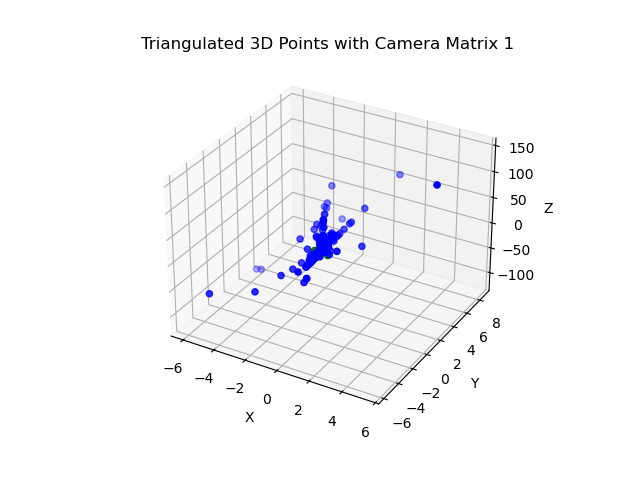

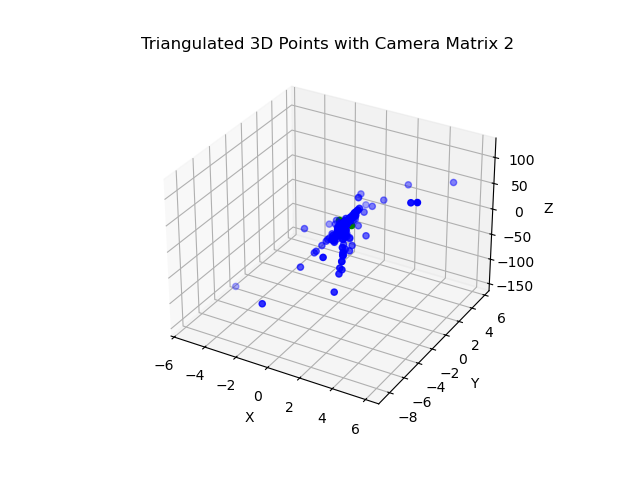

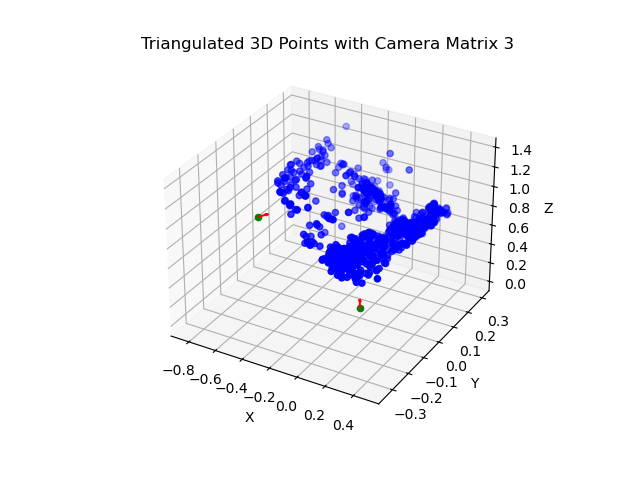

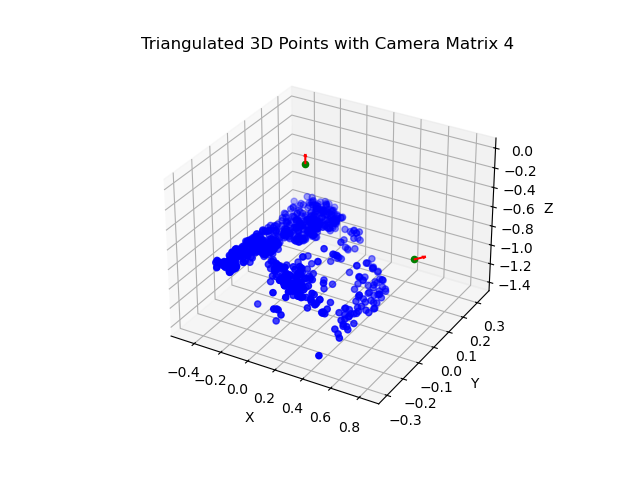

The correct camera matrix is Camera Matrix 3


In [18]:
# ------ Your code here ------

# Compute the 4 possible camera matrices
Ps = extract_P_from_E(E)
print(Ps.shape)
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
# Plot all (4) of them together with the triangulated 3D points X!
inlier_x1 = x1_norm[:, inliers]
inlier_x2 = x2_norm[:, inliers]
Xs_list = []
plt.close('all')
for i,P2 in enumerate(Ps):
    num_points=inlier_x1.shape[1]
    Xs = np.zeros((4, num_points))
    for j in range(num_points):
        pt3d = triangulate_3D_point_DLT(inlier_x1[:, j], inlier_x2[:, j], P1, P2)
        Xs[:, j] = pt3d.flatten()
    Xs = pflat(Xs)
    Xs_list.append(Xs)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xs[0, :], Xs[1, :], Xs[2, :], c='b', marker='o')
    ax.set_title(f'Triangulated 3D Points with Camera Matrix {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')    
    plot_camera(P1, 0.1,ax=ax)
    plot_camera(P2, 0.1, ax=ax)
    plt.show()
# Determine the correct camera matrix based on the triangulated points being in front of both cameras
correct_P = None
for i, Xs in enumerate(Xs_list):
    if np.all(Xs[2, :] > 0):
        correct_P = Ps[i]
        correct_Xs = Xs
        print(f'The correct camera matrix is Camera Matrix {i+1}')
        break
  

### Summary of reconstruction pipeline

In summary, you have performed a 2d-view reconstruction pipeline consisting of the following steps:
1. **Load the two images**, find SIFT features, and match them.

2. **Estimate the essential matrix** robustly using  
   `estimate_E_robust(x1, x2, eps)`.

3. **Compute the four possible camera matrix pairs** for the essential matrix, and for each pair:
   1. Triangulate the 3D points using the camera matrix pair and the matched image points.
   2. Compute the camera centers and principal directions of both cameras.
   3. Plot everything in 3D.

4. **Choose the correct solution** (out of the four) by selecting the one that yields the highest number of 3D points (inliers) lying in front of the cameras.  

The final visualization should resemble the right-most result in the first Figure of Computer Exercise 2 after removing most outliers.

This pipeline will come in handy for the project and somewhat resembles the first stage in any modern SfM pipeline like [COLMAP](https://github.com/colmap/colmap).

#### *Theoretical exercises 3* (see pdf)

## Computer Exercise 3

In this exercise you will use the solution from Computer Exercise 2 as a starting point and locally improve it using the Levenberg-Marquardt method. If you have doubts about the correctness of your solution from the earlier exercise, you can instead use the provided data in `compEx3data.mat` as starting solution (you can load it like `data = sp.io.loadmat('./data/compEx3data.mat')` and then use that for your x and camera matrices).

The goal is to refine the solution **3D points (not camera matrices, those you can assume fixed**).
You will loop over the 3D points and update them one by one using Levenberg-Marquardt (LM), please see the lecture notes or [Wikipedia page on Levenberg–Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) for more information.

In short, LM is an iterative method for minimizing a non-linear least squares objective
\begin{equation}
   F(v)=\|r(v)\|^2, 
\end{equation}
with respect to $v$.
In LM, the update is given by
\begin{equation}
\delta v =  - (J(v)^TJ(v)+\mu I)^{-1}J(v)^Tr(v),
\end{equation}
where $J(v)$ is the Jacobian of $r(v)$ at $v$.
Here $\mu>0$ is a damping factor that is adjusted adaptively and $v$ is the previous solution.
The new solution is $v+\delta v$ and we iterate until convergence (or for a fixed number of iterations).

We can also define the **reprojection error** to be: $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ (as in Equation (2) in the Theoretical Exercises)

In our setting, we have $v=X_j$ and $r(v)=r(X_j)$. Please see the main PDF for some more details about the definition of $r$ (e.g. Equation (3) for the definition).

You will have to implement three functions in this exercise:

1. `(err,res) = compute_reprojection_error(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the reprojection error ($\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $) given two cameras $P_i$, a 3D point $X_j$ and 2D points $x_{ij}$ in the images corresponding to the cameras $P_i$ and the 3D point $X_j$. It also returns the values of all the individual residuals as a second output, i.e., the residual vector $r(\mathbf{X}_j)$.
    
2. `(r,J) = linearize_reproj_err(P_1,P_2,X_j,x_1j,x_2j)`: a function that computes the linearization ($r$ and $J$) as described in Equation (7) in the Theoretical Exercises.
    
3. `delta_X_j = compute_update(r, J, mu)`: a function that computes the LM-update given $r$, $J$ and $\mu$ as described in Equation (9) in the Theoretical Exercises.

The idea is now to use *decoupled* LM, i.e. loop over the 3D points and refine them one by one.

Let's first start by implementing the functions in code!

**NOTE**: Below we have provided suggestion for the function signatures. However, you are free to implement the actual functions however you'd like. For example, you don't have to take the inputs and outputs on the exact form we suggest. This is one way to store the Jacobians, residuals, etc..., feel free to decide how you feel is best.

Compare the total reprojection error (sum of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.
Also compare the median reprojection error (median of $\sum_{i=1}^m \left\|r_{i}(X_j) \right\|^2 $ over all 3D points) before and after running LM.

Finally plot the refined 3D points in the same plot as the originals.

Q: **What do you observe?**

A: The error barely dropped and the 3D points overlap perfectly, which suggests our initial guess was already spot on, confirming the solver is working correctly.

In [ ]:
# Random useful commands:

# Computes the LM update .
# C = J.T @ J + mu * np.eye(J.shape[1])
# c = J.T @ r
# delta = -np.linalg.solve(C, c)

In [ ]:
def compute_reprojection_error(P_1, P_2, X_j, x_1j, x_2j):
    """
    Compute the reprojection error for a single 3D point.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Projection matrices.

    X_j : ndarray (4,)
        3D homogeneous point.

    x_1j, x_2j : ndarray (2,)
        Observed image positions.

    Returns
    -------
    err : float 
        Reprojection error.

    r : Residual vector. For example, an ndarray of shape (2, 2)
        However, you can decide in your own implementation.
    """
    # ------ Your code here ------
    p1_hom = P_1 @ X_j  
    p2_hom = P_2 @ X_j

    x1_proj = p1_hom[:2] / (p1_hom[-1] + 1e-12)
    x2_proj = p2_hom[:2] / (p2_hom[-1] + 1e-12)

    error1=np.linalg.norm(x1_proj[:2]-x_1j)**2
    error2=np.linalg.norm(x2_proj[:2]-x_2j)**2
    err = error1 + error2

    diff1 = x1_proj[:2] - x_1j
    diff2 = x2_proj[:2] - x_2j
    r = np.hstack((diff1, diff2))

    return err,r
    

In [ ]:
def linearize_reproj_err(P_1, P_2, X_j, x_1j, x_2j):
    """
    Linearize the reprojection error for a single 3D point observed in two views.

    Parameters
    ----------
    P_1, P_2 : ndarray (3, 4)
        Camera matrices.

    X_j : ndarray (4,)
        Homogeneous 3D point.

    x_1j, x_2j : ndarray (2,)
        Observed image coordinates for this point in cameras 1 and 2.

    Returns
    -------
    r : Linearization of r. For example an ndarray of shape (4,) representing concatenated reprojection residuals: [r1_x, r1_y, r2_x, r2_y].
        However, you can decide for yourself how you want to store this.

    J : Linearization of J. For example, an ndarray of shape (4, 4) representing a concatenation of the two Jacobians
        However, you can decide for yourself how you want to store this.

    Notes
    -----
    This creates the linear system used in Levenberg-Marquardt.
    """
    # ------ Your code here ------
    X = X_j[:3]  
    X_h = np.append(X, 1.0)

    r = np.zeros(4)
    J = np.zeros((4, 3))
    for i, (P, x_obs) in enumerate(zip([P1, P2], [x_1j, x_2j])):
        u_h = P @ X_h
        u = u_h[:2] / (u_h[2] + 1e-12)
        r[2*i:2*i+2] = u - x_obs

        w = u_h[2]
        du_dX = np.zeros((2,3))
        du_dX[0,:] = (P[0,:3]*w - P[2,:3]*u_h[0]) / (w**2)
        du_dX[1,:] = (P[1,:3]*w - P[2,:3]*u_h[1]) / (w**2)
        J[2*i:2*i+2, :] = du_dX

    return r, J
    

In [ ]:
def compute_update(r, J, mu):
    """
    Compute the LM update step for a single 3D point.

    Parameters
    ----------
    r : For example, ndarray of shape (4,)
        Residual vector.

    J : For example, ndarray of shape (4, 4)
        Jacobian of the residuals w.r.t. the 3D point.

    mu : float
        Levenberg–Marquardt damping parameter.

    Returns
    -------
    delta : ndarray of shape (4,)
        Update ΔX to apply to the 3D point.

    Notes
    -----
    Solves:
        (JᵀJ + μI) δ = -Jᵀ r
    """
    # ------ Your code here ------
    C= J.T @ J + mu * np.eye(3)
    c= J.T @ r
    delta = -np.linalg.solve(C, c)
    return delta

Median Reprojection Error before Bundle Adjustment: 4.225133195281747e-07
Median Reprojection Error after Bundle Adjustment: 4.032349491026654e-07


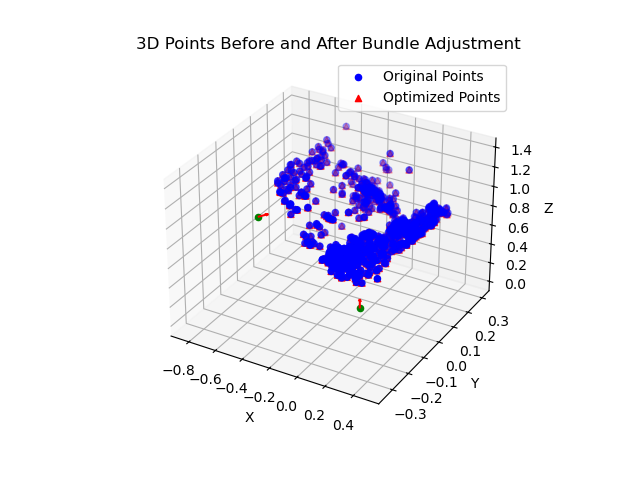

In [ ]:
# ------ Your code here ------
mu_init = 0.1  
n_iters = 10   
# Print the median reprojection error before bundle adjustment
error_reproj = []
x1_obs = x1_norm[:2, inliers]
x2_obs = x2_norm[:2, inliers]
P2 = correct_P
X_point=correct_Xs
X_num=X_point.shape[1]
X = X_point.copy()
error_reproj_bundle=[]
for i in range(X_num):
    err,_=compute_reprojection_error(P1,P2,X[:,i],x1_obs[:,i], x2_obs[:,i])
    error_reproj.append(err)
median_error_before = np.median(error_reproj)
print(f'Median Reprojection Error before Bundle Adjustment: {median_error_before}')
# Perform bundle adjustment by looping through your N points

X_optimized=X.copy()
for i in range(X_num):
    old_err, _ = compute_reprojection_error(P1, P2, X_optimized[:,i], x1_obs[:,i], x2_obs[:,i])
    mu = mu_init
    for k in range(n_iters):
        r_i,J_i=linearize_reproj_err(P1,P2,X_optimized[:,i],x1_obs[:,i], x2_obs[:,i])
        delta_i=compute_update(r_i,J_i,mu)
        X_try = X_optimized[:, i].copy()
        X_try[:3] = X_try[:3] + delta_i      # update only X,Y,Z
        X_try[3] = 1.0 
        new_err, _ = compute_reprojection_error(P1, P2, X_try, x1_obs[:,i], x2_obs[:,i])
        if new_err < old_err:
            X_optimized[:,i] = X_try
            old_err = new_err
            mu /= 10.0
        else:
            mu *= 10.0

# For each point, compute the Levenberg-Marquadt update
# Use the update to update the 3D point (the camera matrices are fixed!)

# Print the median reprojection error after bundle adjustment
for i in range(X_num):
    err_bundle,_=compute_reprojection_error(P1,P2,X_optimized[:,i],x1_obs[:,i], x2_obs[:,i])
    error_reproj_bundle.append(err_bundle)
median_error_after = np.median(error_reproj_bundle)
print(f'Median Reprojection Error after Bundle Adjustment: {median_error_after}')
# Plot the refined 3D points in the same plot as the originals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0, :], X[1, :], X[2, :], c='b', marker='o', label='Original Points')
ax.scatter(X_optimized[0, :], X_optimized[1, :], X_optimized[2, :], c='r', marker='^', label='Optimized Points')
ax.set_title('3D Points Before and After Bundle Adjustment')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plot_camera(P1, 0.1, ax=ax)
plot_camera(P2, 0.1, ax=ax)
plt.show()


## **OPTIONAL**: Computer Exercise 4 (10 points)

Perform an empirical noise sensitivity analysis of your LM-solver from the previous exercise.
Add i.i.d. mean-zero Gaussian noise with standard deviation $\sigma_X\in\{0,0.1\mathrm{m}\}$ to the 3D points and $\sigma_x\in\{0,3\mathrm{px}\}$ to the 2D points (from SIFT), yielding (at least) four noise combinations ($\sigma_X$, $\sigma_x$) to try.
See how the total reprojection error and median reprojection error as computed in the previous exercise varies before and after LM with the added noise.
If you want to, you can test other noise types as well.

Q: **Report your findings with plots and numbers in some reasonable manner.**

A: The Levenberg-Marquardt solver demonstrated high robustness. Even with significant initialization noise ($\sigma_X=0.1$m) which caused a high initial error of $0.032$, the solver successfully converged to the optimal solution with a median error of $\approx 4 \times 10^{-7}$. The solver also effectively handled 2D measurement noise, consistently reducing the reprojection error across all tested noise levels.

In [ ]:
# ------ Your code here ------
x1_obs = x1[:2, :]  # shape (2, N)
x2_obs = x2[:2, :]
f = K[0,0]
sigma_X_level = [0, 0.1]
sigma_x_level = [0, 3.0/f]
print(f"{'Sig_X (m)':<12} {'Sig_x (px)':<12} {'Err Before':<15} {'Err After':<15}")
print("-" * 55)

for sig_X in sigma_X_level:
    for sig_x in sigma_x_level:
        X_noisy = X_point.copy()
        x1_curr = x1_norm[:2, inliers].copy()
        x2_curr = x2_norm[:2, inliers].copy()

        if sig_X > 0:
            noise_3d = np.random.normal(0, sig_X, X_noisy.shape)
            X_noisy[:3, :] += noise_3d[:3,:]
        if sig_x > 0:
            noise_2d_1 = np.random.normal(0, sig_x, x1_curr.shape)
            noise_2d_2 = np.random.normal(0, sig_x, x2_curr.shape)
            x1_curr += noise_2d_1
            x2_curr += noise_2d_2

        error_reproj_noisy_before = []
        for i in range(X_num):
            err_noisy_before, _ = compute_reprojection_error(P1, P2, X_noisy[:, i], x1_curr[:, i], x2_curr[:, i])
            error_reproj_noisy_before.append(err_noisy_before)

        X_opt = X_noisy.copy()

        # Bundle Adjustment
        max_step = 0.1
        for i in range(X_num):
            old_err_noisy, _ = compute_reprojection_error(P1, P2, X_opt[:, i], x1_curr[:, i], x2_curr[:, i])
            mu = mu_init
            for k in range(n_iters):
                r_i, J_i = linearize_reproj_err(P1, P2, X_opt[:, i], x1_curr[:, i], x2_curr[:, i])
                
                delta_i = compute_update(r_i, J_i, mu)
                
                delta_norm = np.linalg.norm(delta_i)
                if delta_norm > max_step:
                    delta_i = delta_i / delta_norm * max_step

                X_try = X_opt[:, i].copy()
                X_try[:3] += delta_i
                X_try[3] = 1.0

                new_err_noisy, _ = compute_reprojection_error(P1, P2, X_try, x1_curr[:, i], x2_curr[:, i])
                
                if new_err_noisy < old_err_noisy:
                    X_opt[:, i] = X_try
                    old_err_noisy = new_err_noisy
                    mu /= 10.0
                else:
                    mu *= 10.0
                    
        error_reproj_noisy_after = []
        for i in range(X_num):
            err_noisy_after, _ = compute_reprojection_error(P1, P2, X_opt[:, i], x1_curr[:, i], x2_curr[:, i])
            error_reproj_noisy_after.append(err_noisy_after)

        median_err_noisy_before = np.median(error_reproj_noisy_before)
        median_err_noisy_after = np.median(error_reproj_noisy_after)
        print(f"{sig_X:<12} {sig_x:<12} {median_err_noisy_before:<15} {median_err_noisy_after:<15}")


Sig_X (m)    Sig_x (px)   Err Before      Err After      
-------------------------------------------------------
0            0            4.225133195281747e-07 4.032349491026654e-07
0            0.001087161349239712 4.509952754228445e-06 8.645981135827493e-07
0.1          0            0.03277418809456852 4.0323494910266786e-07
0.1          0.001087161349239712 0.031708814024719124 9.628999262736101e-07
